In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [2]:
source('../functions.R')
source('../parameters.sh')
source('parameters.sh')


In [3]:
devtools::load_all(multiSnpnet_src_d)


Loading multiSnpnet



In [4]:
# check if the config file has the correct lambda index
find_argmax_lambda_idx(file.path(RData_d, results_sub_d)) %>% print()
rdata_base %>% print()


[1] 60
[1] "output_lambda_60"


In [5]:
# read R Data file
load(file.path(RData_d, results_sub_d, paste0(rdata_base, '.RData')))


In [6]:
# read the trait names
trait_names %>% fread() %>%
rename('GBE_ID'='#GBE_ID') -> trait_names_df


In [7]:
# update the trait names
fit$C %>% colnames() %>%
lapply(function(x){
    setNames(trait_names_df$phenotype_name, trait_names_df$GBE_ID)[[x]]
}) -> colnames_new

colnames(fit$C) <- colnames_new

fit$C %>% colnames() %>% print()


[1] "Monocyte count"    "Neutrophill count" "Eosinophill count"
[4] "Basophill count"   "FVC"               "PEF"              
[7] "FEV1"              "Asthma"           


In [8]:
svd_C <- tsvd_of_C_with_names(fit, rank=rank)


In [32]:
plot_biplot(
    svd_C, 
    component=list('x'=1, 'y'=2),
    label=list('phenotype'=colnames(fit$C), 'variant'=rownames(fit$C)),
    n_labels=list('phenotype'=8, 'variant'=8)
) -> p_biplot


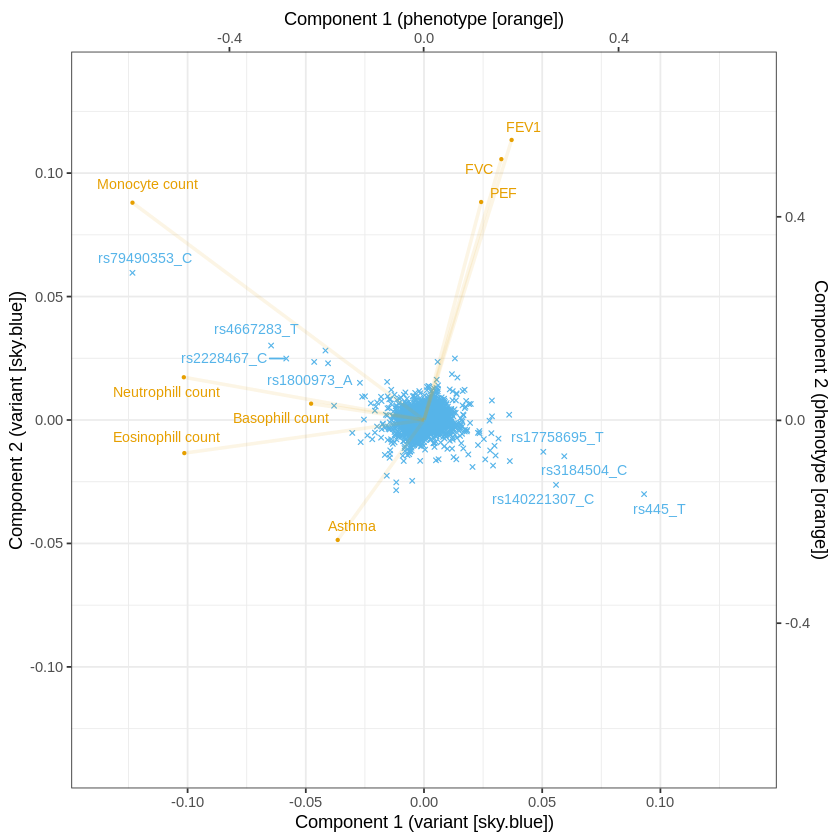

In [36]:
p_biplot

In [38]:
ggsave('biplot.pdf',  p_biplot, width=8, height=8)


## Trait contribution score

In [10]:
svd_C %>% score_contribution() %>%
mutate(component = str_replace(component, '^Component', '')) %>%
mutate(component_order = as.integer(component)) %>%
ggplot(aes(fill=rowname, y=contribution_score, x=reorder(component, component_order))) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
# theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
theme(legend.position='bottom') +
labs(
    x = 'Component',
    y = 'Phenotype contribution score\n(Relative importance of phenotype to each component)',
    fill=''
) + guides(fill=guide_legend(ncol=3)) -> p_contribution


In [11]:
ggsave('contribution.pdf', p_contribution, width=8, height=8)


## Importance of the components (scree plot and trait squared cosine score)


In [12]:
svd_C %>% score_squared_cosine() %>%
bind_rows(
    ((svd_C$d ** 2) / sum(svd_C$d ** 2) ) %>%
    enframe(name = 'component', value='squared_cosine_score') %>%
    mutate(rowname = '(all traits combined)')
) %>%
mutate(component_order=as.numeric(str_replace_all(component, '^Component', ''))) %>%
ggplot(aes(fill=reorder(component, component_order), y=squared_cosine_score, x=rowname)) + 
geom_bar(position="stack", stat="identity", color='black') +
theme_bw(base_size=16) +
coord_flip() + scale_y_reverse() +
theme(legend.position='bottom') +
labs(x = 'Phenotype', y = 'Relative importance of the components for each phenotype', fill='') -> p_squared_cosine


In [13]:
ggsave('squared_cosine.pdf', p_squared_cosine, width=12, height=12)


In [14]:
svd_C %>% score_squared_cosine() %>% 
filter(rowname == 'Asthma') %>%
arrange(-squared_cosine_score) %>%
head(5)

,rowname,component,squared_cosine_score
,<chr>,<chr>,<dbl>
1,Asthma,Component6,0.4434955
2,Asthma,Component5,0.1807995
3,Asthma,Component3,0.1511274
4,Asthma,Component1,0.1184972
5,Asthma,Component2,0.1057382


In [15]:
svd_C %>% score_squared_cosine() %>% 
filter(rowname == 'Basophill count') %>%
arrange(-squared_cosine_score) %>%
head(5)

,rowname,component,squared_cosine_score
,<chr>,<chr>,<dbl>
1,Basophill count,Component5,0.499749419
2,Basophill count,Component4,0.192503051
3,Basophill count,Component1,0.190316832
4,Basophill count,Component6,0.115219874
5,Basophill count,Component2,0.001839606


## variant contribution score

In [16]:
svd_C %>% score_contribution(right_singular_vectors = T) %>%
filter(contribution_score > 0) %>%
group_by(component) %>%
arrange(-contribution_score) %>%
mutate(
    rank = rank(-contribution_score), cum_sum = cumsum(contribution_score)
) -> var_contribution_df


In [17]:
var_contribution_df %>%
mutate(component_idx = as.integer(str_replace(component, '^Component', ''))) %>%
group_by(component) %>% mutate(row_idx = 1:n()) %>%
filter(contribution_score > 1e-4 | rank <= 5000 | row_idx %% 50 == 0) %>%
# do not plot all the points at the tail of the distribution so that
# to speed up the rendering
ggplot(aes(x = rank, y = cum_sum)) + 
geom_point() + facet_wrap( ~ reorder(component, component_idx), ncol=3) +
theme_bw(base_size=16) + ylim(0, 1) -> p_var_contribution_cumsum


In [18]:
ggsave('var_contribution_cumsum.pdf', p_var_contribution_cumsum, width=16, height=16)


## prepare input files for GREAT enrichment

In [19]:
# read variant annotation files
var_annot_f %>%
read_var_annot() %>%
filter(
    ID_ALT %in% rownames(fit$C)
) -> var_annot_df


In [20]:
var_annot_df %>% dim()


[1] 40152    30

In [21]:
d_GREAT_in <- file.path(data_d, results_sub_d, rdata_base, 'GREAT', '1_in_bed')


In [22]:
mkdir_p_if_not_exist(d_GREAT_in)

In [24]:
mkdir_p_if_not_exist(file.path(dirname(d_GREAT_in), '3_out_by_onto'))


In [23]:
for(component_idx in 1:rank){
    var_annot_df %>% 
    filter(ID_ALT %in% get_top_k_variants(var_contribution_df, component_idx)) %>% 
    select(CHROM, POS, POS_e, ID) %>%
    fwrite(file.path(d_GREAT_in, paste0(component_idx, '.bed')), sep='\t', na = "NA", quote=F, col.names=F)    
}


In [31]:
var_contribution_df %>% filter(component == 'Component5') %>% head(5) %>%
left_join(
    var_annot_df %>% select(SYMBOL, ID_ALT, Csq),
    by=c('rowname'='ID_ALT')
)

rowname,component,contribution_score,rank,cum_sum,SYMBOL,Csq
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
rs6662383_T,Component5,0.05973796,1,0.05973796,RP5-940F7.2,others
rs74472890_C,Component5,0.02657894,2,0.08631689,P2RY2,pav
rs4328821_G,Component5,0.02586639,3,0.11218328,NA,others
rs11775560_G,Component5,0.01497919,4,0.12716247,CHD7,intron
rs445_T,Component5,0.01268530,5,0.13984778,CDK6,intron
